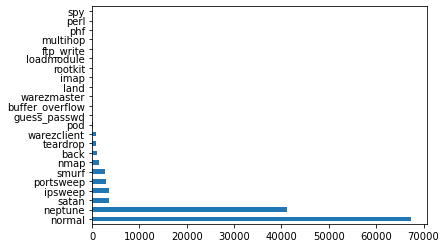

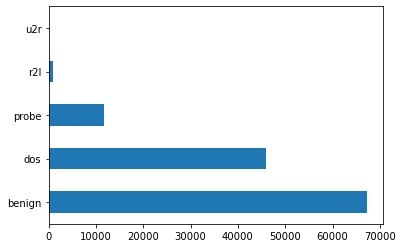

In [1]:
from collections import defaultdict
import os



#STEP 1: LOAD DATA
dataset_root = 'D://Project_Test/easyFL/benchmark/RAW_DATA/NSL-KDD'
#train_x.describe()
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

category = defaultdict(list)
category['benign'].append('normal')

with open('training_attack_types.txt', 'r') as f:
	for line in f.readlines():
		attack, cat = line.strip().split(' ')
		category[cat].append(attack)
#print(category)

attack_mapping = dict((v,k) for k in category for v in category[k])
#print(attack_mapping)

#load train/test files
train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

#READ TRAINING DATA
import pandas as pd
train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
	.map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
.map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)


###STEP 2: UNDERSTAND DATA (visualize)
import matplotlib.pyplot as plt
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()
train_attack_types.plot(kind='barh')
plt.show()
train_attack_cats.plot(kind='barh')
plt.show()


In [2]:
#DATA PREPARATION
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)
feature_names = defaultdict(list)
with open('kddcup.names.txt', 'r') as f:
	for line in f.readlines()[1:]:
		name, nature = line.strip()[:-1].split(': ')
		feature_names[nature].append(name)
print(feature_names)

defaultdict(<class 'list'>, {'continuous': ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'], 'symbolic': ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']})


In [3]:
#FEATURE ENGINEERING
# Concatenate DataFrames
combined_df_raw = pd.concat([train_x_raw, test_x_raw])
# Keep track of continuous, binary, and nominal features
continuous_features = feature_names['continuous']
continuous_features.remove('root_shell')			#Dataset has an error
binary_features = ['land','logged_in','root_shell', 'su_attempted','is_host_login', 'is_guest_login']
nominal_features = list(set(feature_names['symbolic']) - set(binary_features))
# Generate dummy variables
combined_df = pd.get_dummies(combined_df_raw, \
columns=feature_names['symbolic'], \
drop_first=True)
# Separate into training and test sets again
train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]
# Keep track of dummy variables
dummy_variables = list(set(train_x)-set(combined_df_raw))
#train_x.describe()

In [4]:
#NORMALIZATION (src_bytes > num_failed_logs by 10^7)
#what is normalization? show pictures
from sklearn.preprocessing import StandardScaler
# Fit StandardScaler to the training data
standard_scaler = StandardScaler().fit(train_x[continuous_features])
# Standardize training data
train_x[continuous_features] = \
	standard_scaler.transform(train_x[continuous_features])
# Standardize test data with scaler fitted to training data
test_x[continuous_features] = \
	standard_scaler.transform(test_x[continuous_features])

D:\work\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
D:\work\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [5]:
#STEP 5: CLASSIFICATION
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss


classifier = RandomForestClassifier()
classifier.fit(train_x, train_Y)
pred_y = classifier.predict(test_x)

In [6]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score

In [8]:
target_names = ['benign', 'dos', 'probe', 'r2l', 'u2r']
print(f'准确率: {accuracy_score(test_Y, pred_y)}')
print(f'混淆矩阵:')
print(confusion_matrix(test_Y, pred_y))
print(f'分类报告:')
print(classification_report(test_Y, pred_y, target_names=target_names, digits=3))
f1 = f1_score(pred_y, test_Y, average='macro')
print(f'f1_score  is {f1}')

准确率: 0.7434794180269695
混淆矩阵:
[[9460   67  183    0    1]
 [1840 5727   69    0    0]
 [ 785  166 1472    0    0]
 [2471    0    2  100    1]
 [ 195    0    0    3    2]]
分类报告:
              precision    recall  f1-score   support

      benign      0.641     0.974     0.773      9711
         dos      0.961     0.750     0.842      7636
       probe      0.853     0.608     0.710      2423
         r2l      0.971     0.039     0.075      2574
         u2r      0.500     0.010     0.020       200

    accuracy                          0.743     22544
   macro avg      0.785     0.476     0.484     22544
weighted avg      0.809     0.743     0.703     22544

f1_score  is 0.48395701994958334


In [9]:
from sklearn.ensemble import RandomForestClassifier
# 贝叶斯调参优化随机森林
from bayes_opt import BayesianOptimization

ModuleNotFoundError: No module named 'bayes_opt'

In [ ]:
def RF_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    val = cross_val_score(
            RandomForestClassifier(n_estimators=int(n_estimators),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf = int(min_samples_leaf),

                                   random_state=2,
                                   n_jobs=-1),
            train_x, train_y, scoring='f1', cv=5
    ).mean()

    return val

def flow_training():

    # 确定取值空间
    pbounds = {'n_estimators': (10, 300),  # 表示取值范围为10至300
                   'max_depth': (5, 20),
                   'min_samples_split': (2, 40),
                   'min_samples_leaf': (1, 10)
                }

    RF_bo = BayesianOptimization(
            f=self.RF_evaluate,  # 目标函数
            pbounds=pbounds,  # 取值空间
            verbose=2,  # verbose = 2 时打印全部，verbose = 1 时打印运行中发现的最大值，verbose = 0 将什么都不打印
            random_state=1,
    )

    RF_bo.maximize()

    print(RF_bo.max)
    res = RF_bo.max
    params_max = res['params']
    print(params_max)
    

In [ ]:
flow_training()